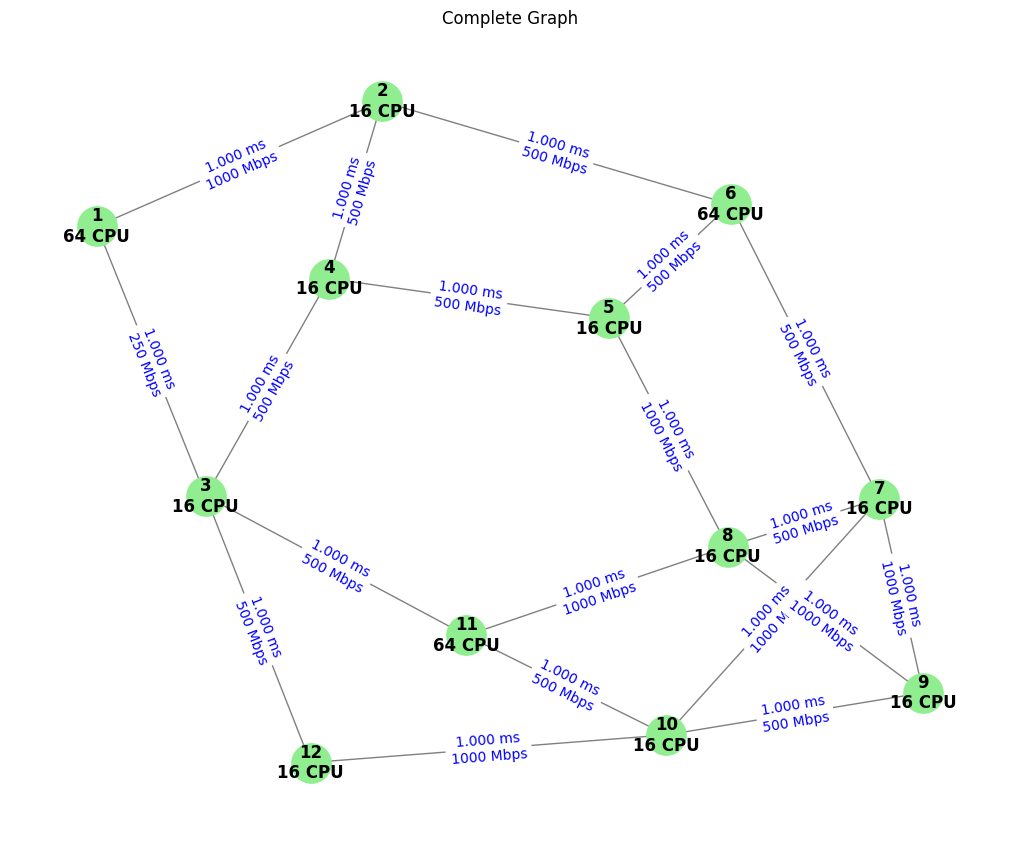

In [1]:
from topology import topology_bayern, draw_graph, topologie_finlande
from generate_slices import generate_random_slices
from milp.topology_to_instance import build_instance_from_topology
from milp.solver_gurobi import solve_gurobi      
from milp.adapter import MILPResultAdapterGurobi

import pandas as pd

# === Topology ===
G = topologie_finlande()
draw_graph(G)


In [2]:

# === Generate slices ===
vnf_profiles = [
    {"cpu": 2, "throughput": 140, "latency": 120},
    {"cpu": 4, "throughput": 150, "latency": 180},
    {"cpu": 6, "throughput": 160, "latency": 200},
    {"cpu": 8, "throughput": 175, "latency": 250}
]

slices = generate_random_slices(G, vnf_profiles, num_slices=20, num_vnfs_per_slice=3)

slices

[([{'id': 'vnf0_0', 'cpu': 4, 'throughput': 150, 'latency': 180, 'slice': 0},
   {'id': 'vnf0_1', 'cpu': 8, 'throughput': 175, 'latency': 250, 'slice': 0},
   {'id': 'vnf0_2', 'cpu': 4, 'throughput': 150, 'latency': 180, 'slice': 0}],
  [{'from': 'vnf0_0', 'to': 'vnf0_1', 'bandwidth': 150, 'latency': 180},
   {'from': 'vnf0_1', 'to': 'vnf0_2', 'bandwidth': 175, 'latency': 250}]),
 ([{'id': 'vnf1_0', 'cpu': 2, 'throughput': 140, 'latency': 120, 'slice': 1},
   {'id': 'vnf1_1', 'cpu': 4, 'throughput': 150, 'latency': 180, 'slice': 1},
   {'id': 'vnf1_2', 'cpu': 6, 'throughput': 160, 'latency': 200, 'slice': 1}],
  [{'from': 'vnf1_0', 'to': 'vnf1_1', 'bandwidth': 140, 'latency': 120},
   {'from': 'vnf1_1', 'to': 'vnf1_2', 'bandwidth': 150, 'latency': 180}]),
 ([{'id': 'vnf2_0', 'cpu': 6, 'throughput': 160, 'latency': 200, 'slice': 2},
   {'id': 'vnf2_1', 'cpu': 2, 'throughput': 140, 'latency': 120, 'slice': 2},
   {'id': 'vnf2_2', 'cpu': 4, 'throughput': 150, 'latency': 180, 'slice': 2}],

In [3]:
# === Build MILP instance ===
from milp.formulation import MILPInstance
from milp.solver_gurobi import solve_gurobi
from milp.adapter import MILPResultAdapterGurobi
import pandas as pd

# Create MILP instance directly from your topology and slices
instance = MILPInstance(G, slices)
print(instance)

# === Solve MILP with Gurobi ===
res = solve_gurobi(instance, msg=True)   # msg=False to suppress logs
print(f"Status: {res.status_str} | Objective: {res.objective:.4f}")

# === Adapt to heuristic-like format ===
milp_result = MILPResultAdapterGurobi(res, instance)

df_milp = pd.DataFrame([{
    "status": res.status_str,
    "objective": res.objective,
    "num_slices": len(instance.S),
    "num_vnfs": sum(len(instance.V_of_s[s]) for s in instance.S)
}])

print(milp_result)
print("Placed VNFs:", milp_result.placed_vnfs)
print("Routed VLs:", milp_result.routed_vls)


<MILPInstance | nodes=12 edges=19 slices=20 vnfs=60>
Set parameter Username
Academic license - for non-commercial use only - expires 2026-10-09
Set parameter OutputFlag to value 1


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Core(TM) Ultra 7 155H, instruction set [SSE2|AVX|AVX2]
Thread count: 11 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 913 rows, 1542 columns and 7733 nonzeros
Model fingerprint: 0xc9319702
Variable types: 31 continuous, 1511 integer (1511 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 191 rows and 391 columns
Presolve time: 0.02s
Presolved: 722 rows, 1151 columns, 4851 nonzeros
Variable types: 0 continuous, 1151 integer (1151 binary)

Root relaxation: objective 2.843879e+01, 867 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   28.43879    0  208        

In [4]:
def print_solution_gurobi(res, instance, eps=1e-6):
    """
    Pretty-print MILP solution from Gurobi result.
    Works with GurobiSolveResult (res.values dict).
    """
    print("=== MILP Solution (Gurobi) ===")
    if res.objective is not None:
        print(f"Objective value: {res.objective:.3f}")
    else:
        print("Objective value: None (no optimal solution)")
    print(f"Status: {res.status_str}\n")

    vals = res.values

    # -------- VNF allocations (argmax over nodes) --------
    print("VNF allocations:")
    placed = {}
    for s in instance.S:
        for i in instance.V_of_s[s]:
            candidates = [(n, vals.get(("v", i, n), 0.0) or 0.0) for n in instance.N]
            n_star, v_star = max(candidates, key=lambda t: t[1])
            placed[i] = (n_star, v_star)
            print(f"  - {i} -> Node {n_star}  (value={v_star:.3f}, sum={sum(v for _, v in candidates):.3f})")

    # -------- Virtual Links (flows f[e,s,(i,j)]) --------
    print("\nVirtual Link allocations:")
    for s in instance.S:
        vnf_ids = instance.V_of_s[s]
        for q in range(len(vnf_ids) - 1):
            i, j = vnf_ids[q], vnf_ids[q + 1]
            used_edges = []
            for e in instance.E:
                val = vals.get(("f", e, s, (i, j)), 0.0) or 0.0
                if val > 0.5 - eps:
                    used_edges.append(e)
            if used_edges:
                print(f"  - Slice {s}, VL ({i}->{j}) uses edges: {used_edges}")
            else:
                print(f"  - Slice {s}, VL ({i}->{j}) NOT routed")

    # -------- Node utilization --------
    print("\nNode utilization:")
    for n in instance.N:
        u_val = vals.get(("u", n), 0.0) or 0.0
        z_val = vals.get(("z", n), 0.0) or 0.0
        print(f"  - Node {n}: u={u_val:.2f}, z={int(round(z_val))}")

    # -------- Link utilization --------
    print("\nLink utilization:")
    for e in instance.E:
        rho_val = vals.get(("rho", e), 0.0) or 0.0
        w_val = vals.get(("w", e), 0.0) or 0.0
        if rho_val > eps or w_val > 0.5 - eps:
            print(f"  - Link {e}: rho={rho_val:.2f}, w={int(round(w_val))}")


In [5]:
instance = MILPInstance(G, slices)
res = solve_gurobi(instance, msg=True)
print_solution_gurobi(res, instance)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Core(TM) Ultra 7 155H, instruction set [SSE2|AVX|AVX2]
Thread count: 11 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 913 rows, 1542 columns and 7733 nonzeros
Model fingerprint: 0xc9319702
Variable types: 31 continuous, 1511 integer (1511 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 191 rows and 391 columns
Presolve time: 0.02s
Presolved: 722 rows, 1151 columns, 4851 nonzeros
Variable types: 0 continuous, 1151 integer (1151 binary)

Root relaxation: objective 2.843879e+01, 867 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     

In [6]:
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}
link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})
link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})



In [7]:

from a_star import run_astar
from run_abo_full_batch import run_abo_full_batch
from run_fabo_full_batch import run_fabo_full_batch
from first_fit import run_first_fit
from best_fit import run_best_fit
from copy import deepcopy


In [8]:

df_astar, results_astar = run_astar(G, slices, node_capacity_base, link_capacity_base)
df_abo, abo_results = run_abo_full_batch(G, slices, node_capacity_base, link_latency ,link_capacity_base)
df_fabo, fabo_results = run_fabo_full_batch(G, slices, node_capacity_base, link_latency, link_capacity_base)
df_ff, ff_results = run_first_fit(G, slices, node_capacity_base, link_capacity_base, link_latency)
df_bestfit, bestfit_results = run_best_fit(G, slices, node_capacity_base, link_capacity_base, link_latency)


df_astar
df_abo
df_fabo
df_bestfit


[INFO][A*] === Solving slice 1 with 3 VNFs and 2 VLs ===
[INFO][A*] Placed vnf0_0 on node 1 (use=4, remaining=60).
[INFO][A*] Placed vnf0_0 on node 6 (use=4, remaining=60).
[INFO][A*] Placed vnf0_0 on node 11 (use=4, remaining=60).
[INFO][A*] Placed vnf0_0 on node 2 (use=4, remaining=12).
[INFO][A*] Placed vnf0_0 on node 3 (use=4, remaining=12).
[INFO][A*] Placed vnf0_0 on node 4 (use=4, remaining=12).
[INFO][A*] Placed vnf0_0 on node 5 (use=4, remaining=12).
[INFO][A*] Placed vnf0_0 on node 7 (use=4, remaining=12).
[INFO][A*] Placed vnf0_0 on node 8 (use=4, remaining=12).
[INFO][A*] Placed vnf0_0 on node 9 (use=4, remaining=12).
[INFO][A*] Placed vnf0_0 on node 10 (use=4, remaining=12).
[INFO][A*] Placed vnf0_0 on node 12 (use=4, remaining=12).
[INFO][A*] Placed vnf0_1 on node 6 (use=8, remaining=56).
[INFO][A*] Placed vnf0_1 on node 11 (use=8, remaining=56).
[DEBUG][A*] Anti-affinity: vnf0_1 cannot be placed on node 1 (another VNF of slice 0 already there).
[INFO][A*] Placed vnf0_1 

,slice,accepted,g_cost
0,1,True,3.0
1,2,True,3.0
2,3,True,2.0
3,4,True,3.0
4,5,True,3.0
5,6,True,3.0
6,7,True,2.0
7,8,True,2.0
8,9,True,2.0
9,10,True,4.0


In [9]:
from milp.solver_gurobi import solve_gurobi
from milp.adapter import MILPResultAdapterGurobi

# monta a instância como antes
# instance = MILPInstance(G, slices)

# === Resolve MILP com Gurobi ===
res = solve_gurobi(instance, msg=True)   # msg=False se quiser ocultar o log
print("Status:", res.status_str, " Objective:", res.objective)

# === Adapta para formato compatível com heurísticas ===
milp_result = MILPResultAdapterGurobi(res, instance)

# === Integra nas métricas ===
method_results = {
    "A*": results_astar,
    "ABO": abo_results,
    "FABO": fabo_results,
    "First Fit": ff_results,
    "Best-fit": bestfit_results,
    "MILP (Gurobi)": [milp_result],
}

# o loop de métricas (compute_energy_*) continua funcionando normalmente


Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Core(TM) Ultra 7 155H, instruction set [SSE2|AVX|AVX2]
Thread count: 11 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 913 rows, 1542 columns and 7733 nonzeros
Model fingerprint: 0xc9319702
Variable types: 31 continuous, 1511 integer (1511 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 191 rows and 391 columns
Presolve time: 0.03s


Presolved: 722 rows, 1151 columns, 4851 nonzeros
Variable types: 0 continuous, 1151 integer (1151 binary)

Root relaxation: objective 2.843879e+01, 867 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   28.43879    0  208          -   28.43879      -     -    0s
     0     0   33.39657    0  226          -   33.39657      -     -    0s
H    0     0                      52.0025000   33.39657  35.8%     -    0s
     0     0   34.19851    0  236   52.00250   34.19851  34.2%     -    0s
     0     0   34.22422    0  241   52.00250   34.22422  34.2%     -    0s
     0     0   37.92280    0  267   52.00250   37.92280  27.1%     -    0s
H    0     0                      51.8550000   37.92280  26.9%     -    0s
     0     0   37.92280    0  267   51.85500   37.92280  26.9%     -    0s
     0     0   39.48373    0  211   51.85500   39.483

In [10]:
# All comments in English
import matplotlib.pyplot as plt
import networkx as nx

def plot_solution_gurobi(G, res, instance):
    """
    Visualize MILP solution (Gurobi).
    - Active nodes in green, inactive in gray
    - Node labels show VNFs placed
    - Active links highlighted in red
    """
    pos = nx.spring_layout(G, seed=42)
    vals = res.values

    # --- Collect VNFs placed on each node ---
    vnfs_per_node = {n: [] for n in instance.N}
    active_nodes = set()

    for s in instance.S:
        for i in instance.V_of_s[s]:
            for n in instance.N:
                if vals.get(("v", i, n), 0.0) > 0.5:
                    vnfs_per_node[n].append(i)

    for n in instance.N:
        if vals.get(("z", n), 0.0) > 0.5:
            active_nodes.add(n)

    # --- Node colors ---
    node_colors = ["lightgreen" if n in active_nodes else "lightgray" for n in G.nodes()]

    # --- Draw base graph ---
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, node_color=node_colors, node_size=800, with_labels=False)

    # --- Node labels: node id + VNFs placed ---
    labels = {}
    for n in G.nodes():
        if vnfs_per_node[n]:
            labels[n] = f"{n}\n" + ",".join(vnfs_per_node[n])
        else:
            labels[n] = str(n)
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    # --- Highlight active links (w[e] = 1) ---
    active_edges = []
    for e in instance.E:
        if vals.get(("w", e), 0.0) > 0.5:
            active_edges.append(e)
    nx.draw_networkx_edges(G, pos, edgelist=active_edges, edge_color="red", width=2)

    plt.title("MILP Solution (Gurobi)")
    plt.show()


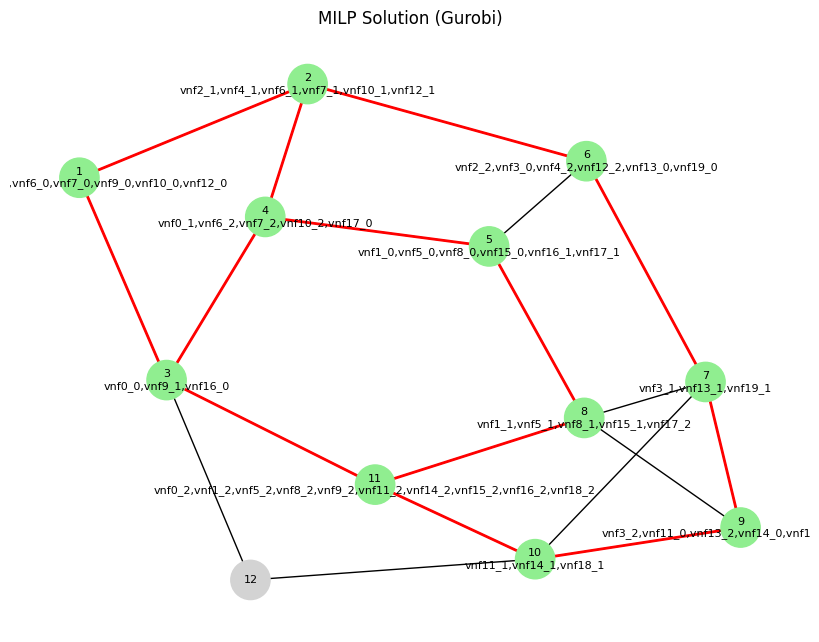

In [11]:
instance = MILPInstance(G, slices)
res = solve_gurobi(instance, msg=False)
plot_solution_gurobi(G, res, instance)

In [12]:
def _is_vl_routed(result, slice_idx, src, dst):
    """
    Check if a VL (src->dst) is routed in 'result', accepting different key styles:
    - (src, dst)
    - (dst, src)                # reversed order
    - (slice_idx, (src, dst))
    - (slice_idx, (dst, src))
    Accepts either a path (list of nodes) or a list of edges (u,v).
    Works with both CBC and Gurobi adapters.
    """
    if not result or not getattr(result, "routed_vls", None):
        return False

    # direct heuristic keys
    if (src, dst) in result.routed_vls:
        val = result.routed_vls[(src, dst)]
        return bool(val)
    if (dst, src) in result.routed_vls:
        val = result.routed_vls[(dst, src)]
        return bool(val)

    # MILP adapter style
    key1 = (slice_idx, (src, dst))
    key2 = (slice_idx, (dst, src))
    if key1 in result.routed_vls:
        return bool(result.routed_vls[key1])
    if key2 in result.routed_vls:
        return bool(result.routed_vls[key2])

    return False


In [13]:
def count_accepted_slices(results, slices, eps=1e-6, verbose=True):
    """
    Count how many slices are successfully accepted.

    A slice is considered accepted if:
      - all its VNFs are placed
      - all its Virtual Links (VLs) are routed

    Compatible with:
      - heuristic results
      - MILP (CBC) results
      - MILP (Gurobi) results
    """
    accepted = 0
    for s_idx, result in enumerate(results):
        if not result or not hasattr(result, "placed_vnfs") or not hasattr(result, "routed_vls"):
            if verbose:
                print(f"[Slice {s_idx}] REJECTED: missing placed_vnfs or routed_vls")
            continue

        vnfs, vls = slices[s_idx]

        # --- Check VNF placement ---
        placed_ok = all(v["id"] in result.placed_vnfs for v in vnfs)
        if not placed_ok:
            if verbose:
                missing = [v["id"] for v in vnfs if v["id"] not in result.placed_vnfs]
                print(f"[Slice {s_idx}] REJECTED: missing VNFs {missing}")
            continue

        # --- Check VL routing ---
        vls_ok = True
        for vl in vls:
            src, dst = vl["from"], vl["to"]

            if (src, dst) in result.routed_vls or (dst, src) in result.routed_vls:
                continue
            elif (s_idx, (src, dst)) in result.routed_vls or (s_idx, (dst, src)) in result.routed_vls:
                continue
            else:
                vls_ok = False
                if verbose:
                    print(f"[Slice {s_idx}] REJECTED: VL ({src}->{dst}) not routed")
                break

        if vls_ok:
            accepted += 1
            if verbose:
                print(f"[Slice {s_idx}] ACCEPTED ✓ (all VNFs placed, all VLs routed)")

    if verbose:
        print(f"\nTotal slices accepted: {accepted}/{len(slices)}")
    return accepted


In [14]:
print("=== Sanity check for all methods ===")
for method_name, result_list in method_results.items():
    if not result_list:
        continue
    print(f"\n--- {method_name} ---")
    count_accepted_slices(result_list, slices, verbose=True)



=== Sanity check for all methods ===

--- A* ---
[Slice 0] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 1] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 2] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 3] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 4] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 5] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 6] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 7] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 8] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 9] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 10] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 11] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 12] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 13] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 14] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 15] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 16] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 17

In [15]:
def sanity_check_milp_gurobi(res, instance, slices, eps=1e-6):
    """
    Sanity check for MILP (Gurobi) results.
    Prints node CPU usage, slice acceptance, and routing correctness.
    Compatible with GurobiSolveResult.
    """
    print("=== Sanity check MILP (Gurobi) ===")
    if res.objective is not None:
        print(f"Objective value: {res.objective:.3f}")
    else:
        print("Objective value: None (no optimal solution)")
    print(f"Status: {res.status_str}")

    var_dict = res.values  # dict: keys are tuples like ('v', i, n), ('f', e, s, (i,j)), etc.

    # --- CPU usage per node ---
    cpu_used = {n: 0 for n in instance.N}
    for key, value in var_dict.items():
        if not isinstance(key, tuple):
            continue
        if key[0] == "v" and value > 0.5:
            _, i, n = key
            cpu_used[n] += instance.CPU_i[i]

    print("\nNode CPU usage:")
    for n in instance.N:
        used = cpu_used[n]
        cap = instance.CPU_cap[n]
        warn = "⚠️" if used > cap + eps else ""
        print(f"  Node {n}: used {used} / cap {cap} {warn}")

    # --- Slice acceptance check ---
    accepted = 0
    for s in instance.S:
        vnfs, vls = slices[s]
        ok = True
        print(f"\n[Slice {s}]")

        # VNFs
        for v in vnfs:
            i = v["id"]
            assigned_nodes = [
                n for n in instance.N
                if ("v", i, n) in var_dict and var_dict[("v", i, n)] > 0.5
            ]
            if assigned_nodes:
                print(f"  VNF {i} -> {assigned_nodes}")
            else:
                print(f"  VNF {i} NOT allocated")
                ok = False

        # VLs
        for vl in vls:
            i, j = vl["from"], vl["to"]
            used_edges = []
            for key, value in var_dict.items():
                if not isinstance(key, tuple):
                    continue
                if key[0] == "f" and value > 0.5:
                    _, e, s_idx, (src, dst) = key
                    if s_idx == s and {src, dst} == {i, j}:
                        used_edges.append(e)
            if used_edges:
                print(f"  VL ({i}->{j}) routed via {used_edges}")
            else:
                print(f"  VL ({i}->{j}) NOT routed")
                ok = False

        if ok:
            print(f"  -> Slice {s} ACCEPTED ✓")
            accepted += 1
        else:
            print(f"  -> Slice {s} REJECTED ✗")

    print(f"\nTotal slices accepted: {accepted}/{len(instance.S)}")


In [16]:
print(type(res))
print(dir(res))


<class 'milp.solver_gurobi.GurobiSolveResult'>
['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'objective', 'status_code', 'status_str', 'values']


In [17]:
sanity_check_milp_gurobi(res, instance, slices)

=== Sanity check MILP (Gurobi) ===
Objective value: 44.119
Status: 2

Node CPU usage:
  Node 1: used 52 / cap 64 
  Node 2: used 16 / cap 16 
  Node 3: used 16 / cap 16 
  Node 4: used 16 / cap 16 
  Node 5: used 16 / cap 16 
  Node 6: used 32 / cap 64 
  Node 7: used 16 / cap 16 
  Node 8: used 16 / cap 16 
  Node 9: used 16 / cap 16 
  Node 10: used 16 / cap 16 
  Node 11: used 58 / cap 64 
  Node 12: used 0 / cap 16 

[Slice 0]
  VNF vnf0_0 -> [3]
  VNF vnf0_1 -> [4]
  VNF vnf0_2 -> [11]
  VL (vnf0_0->vnf0_1) routed via [(3, 4)]
  VL (vnf0_1->vnf0_2) routed via [(4, 5), (5, 8), (8, 11)]
  -> Slice 0 ACCEPTED ✓

[Slice 1]
  VNF vnf1_0 -> [5]
  VNF vnf1_1 -> [8]
  VNF vnf1_2 -> [11]
  VL (vnf1_0->vnf1_1) routed via [(5, 8)]
  VL (vnf1_1->vnf1_2) routed via [(8, 11)]
  -> Slice 1 ACCEPTED ✓

[Slice 2]
  VNF vnf2_0 -> [1]
  VNF vnf2_1 -> [2]
  VNF vnf2_2 -> [6]
  VL (vnf2_0->vnf2_1) routed via [(1, 2)]
  VL (vnf2_1->vnf2_2) routed via [(2, 6)]
  -> Slice 2 ACCEPTED ✓

[Slice 3]
  VNF vn

In [18]:
def count_accepted_slices(results, slices, eps=1e-6, verbose=False):
    """
    Count accepted slices across different result types:
      - All VNFs placed
      - All VLs routed

    Handles:
      (A) Heuristics → list with one result per slice (has .placed_vnfs / .routed_vls)
      (B) MILP adapter (CBC or Gurobi) → single aggregated result with routed_vls keys like (s_idx, (src, dst))
      (C) Raw solver result (PulpSolveResult or GurobiSolveResult) → single result with .values dict
    """
    if not results:
        return 0

    # --- Helper: check routed VL presence with multiple key styles
    def _vl_present(routed_vls, s_idx, src, dst):
        """Check several key conventions: (src,dst), (dst,src), (s,(src,dst)), (s,(dst,src))."""
        if (src, dst) in routed_vls or (dst, src) in routed_vls:
            return True
        key1 = (s_idx, (src, dst))
        key2 = (s_idx, (dst, src))
        return key1 in routed_vls or key2 in routed_vls

    # ----------------------
    # Case C: raw solver result (PuLP or Gurobi)
    # ----------------------
    r0 = results[0]
    if hasattr(r0, "values"):  # works for PulpSolveResult or GurobiSolveResult
        var_dict = r0.values
        accepted = 0
        for s_idx in range(len(slices)):
            vnfs, vls = slices[s_idx]

            # --- VNFs placed ---
            vnfs_ok = True
            for v in vnfs:
                i = v["id"]
                assigned = any(
                    isinstance(k, tuple) and k[0] == "v" and k[1] == i and val > 0.5
                    for k, val in var_dict.items()
                )
                if not assigned:
                    vnfs_ok = False
                    if verbose:
                        print(f"[MILP raw] slice {s_idx}: VNF {i} not allocated")
                    break

            # --- VLs routed ---
            vls_ok = True
            if vnfs_ok:
                for vl in vls:
                    src, dst = vl["from"], vl["to"]
                    routed = any(
                        isinstance(k, tuple)
                        and k[0] == "f"
                        and k[2] == s_idx
                        and set(k[3]) == {src, dst}
                        and val > 0.5
                        for k, val in var_dict.items()
                    )
                    if not routed:
                        vls_ok = False
                        if verbose:
                            print(f"[MILP raw] slice {s_idx}: VL ({src}->{dst}) not routed")
                        break

            if vnfs_ok and vls_ok:
                accepted += 1
                if verbose:
                    print(f"[MILP raw] slice {s_idx}: ACCEPTED ✓")

        if verbose:
            print(f"Total slices accepted (MILP raw): {accepted}/{len(slices)}")
        return accepted

    # ----------------------
    # Case B: MILP adapter (CBC or Gurobi)
    # ----------------------
    is_milp_adapter = (
        len(results) == 1
        and hasattr(r0, "routed_vls")
        and any(isinstance(k, tuple) and len(k) >= 2 and isinstance(k[0], int)
                for k in r0.routed_vls.keys())
    )
    if is_milp_adapter:
        accepted = 0
        placed_vnfs = getattr(r0, "placed_vnfs", {})
        routed_vls = getattr(r0, "routed_vls", {})

        for s_idx in range(len(slices)):
            vnfs, vls = slices[s_idx]
            vnfs_ok = all(v["id"] in placed_vnfs for v in vnfs)

            if not vnfs_ok and verbose:
                missing = [v["id"] for v in vnfs if v["id"] not in placed_vnfs]
                print(f"[MILP adapter] slice {s_idx}: missing VNFs {missing}")

            vls_ok = True
            if vnfs_ok:
                for vl in vls:
                    src, dst = vl["from"], vl["to"]
                    if not _vl_present(routed_vls, s_idx, src, dst):
                        vls_ok = False
                        if verbose:
                            print(f"[MILP adapter] slice {s_idx}: VL ({src}->{dst}) not routed")
                        break

            if vnfs_ok and vls_ok:
                accepted += 1
                if verbose:
                    print(f"[MILP adapter] slice {s_idx}: ACCEPTED ✓")

        if verbose:
            print(f"Total slices accepted (MILP adapter): {accepted}/{len(slices)}")
        return accepted

    # ----------------------
    # Case A: heuristics (one result per slice)
    # ----------------------
    accepted = 0
    for s_idx, result in enumerate(results):
        if not result or not hasattr(result, "placed_vnfs") or not hasattr(result, "routed_vls"):
            continue
        vnfs, vls = slices[s_idx]

        vnfs_ok = all(v["id"] in result.placed_vnfs for v in vnfs)
        if not vnfs_ok:
            if verbose:
                missing = [v["id"] for v in vnfs if v["id"] not in result.placed_vnfs]
                print(f"[Heuristic] slice {s_idx}: missing VNFs {missing}")
            continue

        vls_ok = all(
            (vl["from"], vl["to"]) in result.routed_vls or (vl["to"], vl["from"]) in result.routed_vls
            for vl in vls
        )
        if not vls_ok and verbose:
            missing = [
                (vl["from"], vl["to"]) for vl in vls
                if (vl["from"], vl["to"]) not in result.routed_vls
                and (vl["to"], vl["from"]) not in result.routed_vls
            ]
            print(f"[Heuristic] slice {s_idx}: missing VLs {missing}")

        if vnfs_ok and vls_ok:
            accepted += 1
            if verbose:
                print(f"[Heuristic] slice {s_idx}: ACCEPTED ✓")

    if verbose:
        print(f"Total slices accepted (heuristics): {accepted}/{len(results)}")
    return accepted


In [19]:
from compute_energy import (
    compute_energy_per_node,
    compute_total_bandwidth,
    compute_total_latency,
    compute_energy_per_slice,
    compute_energy_new
)

comparison_rows = []
for method_name, result_list in method_results.items():
    if not result_list:
        continue

    energy_per_slice, _ = compute_energy_per_slice(result_list, slices, node_capacity_base)
    _, _ = compute_energy_per_node(result_list, slices, node_capacity_base)

    total_bw_list = compute_total_bandwidth(result_list, slices)
    total_lat_list = compute_total_latency(result_list, link_latency)
    sum_bw  = sum(b for b in total_bw_list if b is not None)
    sum_lat = sum(l for l in total_lat_list if l is not None)

    normalized_energy = compute_energy_new(result_list, slices, node_capacity_base, link_capacity_base)

    comparison_rows.append({
        "Method": method_name,
        "Slices Accepted": count_accepted_slices(result_list, slices, verbose=False),
        "Total Bandwidth": sum_bw,
        "Total Latency": sum_lat,
        "Total Energy": normalized_energy
    })

df_metrics = pd.DataFrame(comparison_rows).reset_index(drop=True)
display(df_metrics)


,Method,Slices Accepted,Total Bandwidth,Total Latency,Total Energy
0,A*,20,6150,43,22.68750
1,ABO,20,6150,49,22.78125
2,FABO,15,4680,35,22.06250
3,First Fit,20,6150,69,22.78125
4,Best-fit,12,3720,34,20.34375
5,MILP (Gurobi),20,325,88,21.21875


In [20]:
print("MILP routed_vls keys:", list(milp_result.routed_vls.keys()))


MILP routed_vls keys: [(0, ('vnf0_0', 'vnf0_1')), ('vnf0_0', 'vnf0_1'), (0, ('vnf0_1', 'vnf0_2')), ('vnf0_1', 'vnf0_2'), (1, ('vnf1_0', 'vnf1_1')), ('vnf1_0', 'vnf1_1'), (1, ('vnf1_1', 'vnf1_2')), ('vnf1_1', 'vnf1_2'), (2, ('vnf2_0', 'vnf2_1')), ('vnf2_0', 'vnf2_1'), (2, ('vnf2_1', 'vnf2_2')), ('vnf2_1', 'vnf2_2'), (3, ('vnf3_0', 'vnf3_1')), ('vnf3_0', 'vnf3_1'), (3, ('vnf3_1', 'vnf3_2')), ('vnf3_1', 'vnf3_2'), (4, ('vnf4_0', 'vnf4_1')), ('vnf4_0', 'vnf4_1'), (4, ('vnf4_1', 'vnf4_2')), ('vnf4_1', 'vnf4_2'), (5, ('vnf5_0', 'vnf5_1')), ('vnf5_0', 'vnf5_1'), (5, ('vnf5_1', 'vnf5_2')), ('vnf5_1', 'vnf5_2'), (6, ('vnf6_0', 'vnf6_1')), ('vnf6_0', 'vnf6_1'), (6, ('vnf6_1', 'vnf6_2')), ('vnf6_1', 'vnf6_2'), (7, ('vnf7_0', 'vnf7_1')), ('vnf7_0', 'vnf7_1'), (7, ('vnf7_1', 'vnf7_2')), ('vnf7_1', 'vnf7_2'), (8, ('vnf8_0', 'vnf8_1')), ('vnf8_0', 'vnf8_1'), (8, ('vnf8_1', 'vnf8_2')), ('vnf8_1', 'vnf8_2'), (9, ('vnf9_0', 'vnf9_1')), ('vnf9_0', 'vnf9_1'), (9, ('vnf9_1', 'vnf9_2')), ('vnf9_1', 'vnf9_2'

In [21]:
import matplotlib.pyplot as plt
import os

def plot_cpu_usage(G, slices, method_results, results_dir):
    node_capacity = {n: G.nodes[n]["cpu"] for n in G.nodes}
    nodes = list(node_capacity.keys())

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.12
    colors = plt.cm.Set2.colors
    methods = list(method_results.keys())

    for idx, (method_name, result_list) in enumerate(method_results.items()):
        if not result_list:
            continue

        used_cpu = {n: 0 for n in nodes}

        # --- MILP special case ---
        if method_name.startswith("MILP"):
            milp_res = result_list[0]
            if hasattr(milp_res, "placed_vnfs"):
                for vnf_id, n in milp_res.placed_vnfs.items():
                    try:
                        vnf_cpu = next(vnf["cpu"] for s in slices for vnf in s[0] if vnf["id"] == vnf_id)
                        used_cpu[n] += vnf_cpu
                    except StopIteration:
                        continue
        else:
            for r in result_list:
                if r is None or not hasattr(r, "placed_vnfs"):
                    continue
                for vnf_id, n in r.placed_vnfs.items():
                    try:
                        vnf_cpu = next(vnf["cpu"] for s in slices for vnf in s[0] if vnf["id"] == vnf_id)
                        used_cpu[n] += vnf_cpu
                    except StopIteration:
                        continue

        # --- Plot bars ---
        usage = [used_cpu[n] for n in nodes]
        offset = (idx - len(methods) / 2) * bar_width
        positions = [i + offset for i in range(len(nodes))]
        ax.bar(positions, usage, width=bar_width, label=method_name, color=colors[idx % len(colors)])

    # --- Labels and layout ---
    ax.set_title("CPU Utilization per Node")
    ax.set_xlabel("Nodes")
    ax.set_ylabel("CPU (units)")
    ax.set_xticks(range(len(nodes)))
    ax.set_xticklabels(nodes)
    ax.legend()
    plt.grid(axis="y")

    # --- Save instead of show ---
    output_path = os.path.join(results_dir, "cpu_utilization.png")
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"[INFO] Saved CPU utilization chart to {output_path}")



In [22]:
# ==============================
# Pretty-print MILP objective
# Works with:
#  - PulpSolveResult (CBC)  -> res.values: dict with keys like ('u', n), ('z', n), ('rho', e), ('w', e)
#  - SciPy (milp / linprog) -> pass (res, var_index) instead of res.values (see second wrapper)
# ==============================

def latex_name(var):
    """Return a LaTeX-friendly variable name from our tuple key."""
    kind = var[0]
    if kind in ("u", "z"):         # ('u', n)
        return f"{kind}_{{{var[1]}}}"
    if kind in ("rho", "w"):       # ('rho', (i,j))
        i, j = var[1]
        return f"{kind}_{{({i},{j})}}"
    if kind == "v":                # ('v', vnf_id, n)
        return f"v_{{{var[1]},{var[2]}}}"
    if kind == "f":                # ('f', (i,j), s, (src,dst))
        (a,b), s, (src,dst) = var[1], var[2], var[3]
        return f"f_{{({a},{b}),s={s},({src}\\to{dst})}}"
    return str(var)

def objective_to_latex_from_values(instance, values_dict, eps=1e-12):
    """
    Build symbolic and numeric LaTeX for:
        E_total = sum_n (u_n + z_n) + sum_e (rho_e + w_e)
    values_dict: dict mapping tuple keys to floats (e.g., from PulpSolveResult.values)
    """
    # Collect terms
    node_terms = []     # (latex_name, value)
    link_terms = []
    node_val_sum = 0.0
    link_val_sum = 0.0

    # Node side: u_n + z_n
    for n in instance.N:
        u_key = ("u", n)
        z_key = ("z", n)
        u_val = float(values_dict.get(u_key, 0.0))
        z_val = float(values_dict.get(z_key, 0.0))
        node_terms.append( (latex_name(u_key), u_val) )
        node_terms.append( (latex_name(z_key), z_val) )
        node_val_sum += u_val + z_val

    # Link side: rho_e + w_e
    for e in instance.E:
        rho_key = ("rho", e)
        w_key   = ("w", e)
        rho_val = float(values_dict.get(rho_key, 0.0))
        w_val   = float(values_dict.get(w_key, 0.0))
        link_terms.append( (latex_name(rho_key), rho_val) )
        link_terms.append( (latex_name(w_key),   w_val) )
        link_val_sum += rho_val + w_val

    total = node_val_sum + link_val_sum

    # Build symbolic latex
    nodes_sym = " + ".join([f"{nm}" for nm,_ in node_terms]) if node_terms else "0"
    links_sym = " + ".join([f"{nm}" for nm,_ in link_terms]) if link_terms else "0"
    symbolic = (
        r"E_{\text{total}} = \sum_{n\in N}(u_n + z_n) + \sum_{e\in E}(\rho_e + w_e)"
        + r" \;=\; (" + nodes_sym + r") \;+\; (" + links_sym + r")"
    )

    # Build numeric latex with substitution
    nodes_num = " + ".join([f"{nm}={val:.3f}" for nm,val in node_terms if abs(val)>eps]) or "0"
    links_num = " + ".join([f"{nm}={val:.3f}" for nm,val in link_terms if abs(val)>eps]) or "0"
    numeric = (
        r"E_{\text{total}} = (" + nodes_num + r") \;+\; (" + links_num + r")"
        + rf" \;=\; {node_val_sum:.3f} + {link_val_sum:.3f} \;=\; \boxed{{{total:.3f}}}"
    )

    return symbolic, numeric, {
        "node_sum": node_val_sum,
        "link_sum": link_val_sum,
        "total": total
    }

def print_objective_expression_milp(res, instance):
    """Convenience printer for PulpSolveResult (CBC)."""
    values_dict = res.values  # expects tuple-keyed dict
    sym, num, parts = objective_to_latex_from_values(instance, values_dict)
    print("=== Objective (symbolic) ===")
    print(sym)
    print("\n=== Objective (with values) ===")
    print(num)
    print(f"\n[Decomposition] nodes={parts['node_sum']:.3f}  links={parts['link_sum']:.3f}  total={parts['total']:.3f}")

# --- If you also want to support SciPy results (res, var_index) ---
def values_from_scipy(res, var_index):
    """Convert SciPy (res, var_index) into the same tuple-keyed dict used above."""
    out = {}
    for key, idx in var_index.items():
        out[key] = float(res.x[idx])
    return out

def print_objective_expression_scipy(res, var_index, instance):
    values_dict = values_from_scipy(res, var_index)
    sym, num, parts = objective_to_latex_from_values(instance, values_dict)
    print("=== Objective (symbolic) ===")
    print(sym)
    print("\n=== Objective (with values) ===")
    print(num)
    print(f"\n[Decomposition] nodes={parts['node_sum']:.3f}  links={parts['link_sum']:.3f}  total={parts['total']:.3f}")


In [23]:
import os
from datetime import datetime

def create_simulation_folder(base_dir="results"):
    """
    Create a new timestamped folder inside base_dir to store simulation outputs.
    Example: results/2025-10-13_21-45-02/
    """
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    sim_dir = os.path.join(base_dir, timestamp)
    os.makedirs(sim_dir, exist_ok=True)
    print(f"[INFO] Simulation folder created: {sim_dir}")
    return sim_dir


In [24]:
results_dir = create_simulation_folder()


[INFO] Simulation folder created: results/2025-10-13_11-24-43


In [25]:
num_slices = len(slices)
num_vnfs_total = sum(len(v[0]) for v in slices)

summary_info = {
    "timestamp": [datetime.now().strftime("%Y-%m-%d %H:%M:%S")],
    "num_slices": [num_slices],
    "num_vnfs_total": [num_vnfs_total]
}

import pandas as pd
df_info = pd.DataFrame(summary_info)
df_info.to_csv(f"{results_dir}/experiment_info.csv", index=False)
df_astar.to_csv(f"{results_dir}/astar_results.csv", index=False)
df_abo.to_csv(f"{results_dir}/abo_results.csv", index=False)
df_fabo.to_csv(f"{results_dir}/fabo_results.csv", index=False)
df_bestfit.to_csv(f"{results_dir}/bestfit_results.csv", index=False)
df_ff.to_csv(f"{results_dir}/ff_results.csv", index=False)
df_milp.to_csv(f"{results_dir}/milp_results.csv", index=False)
df_metrics.to_csv(f"{results_dir}/metrics.csv", index=False)


In [26]:
with open(f"{results_dir}/log.txt", "w") as f:
    f.write(f"Experiment timestamp: {datetime.now()}\n")
    f.write(f"Number of slices: {num_slices}\n")
    f.write(f"Number of VNFs: {num_vnfs_total}\n")
    f.write("\n=== Summary ===\n")
    f.write(df_astar.to_string(index=False))
    f.write(df_abo.to_string(index=False))
    f.write(df_fabo.to_string(index=False))
    f.write(df_bestfit.to_string(index=False))
    f.write(df_ff.to_string(index=False))
    f.write(df_metrics.to_string(index=False))
    f.write("\n\n=== MILP ===\n")
    f.write(df_milp.to_string(index=False))


In [27]:
results_dir = create_simulation_folder()

num_slices = len(slices)
num_vnfs_total = sum(len(v[0]) for v in slices)
plot_cpu_usage(G, slices, method_results, results_dir)
print(f"[INFO] Running simulation with {num_slices} slices ({num_vnfs_total} VNFs total).")


[INFO] Simulation folder created: results/2025-10-13_11-24-43
[INFO] Saved CPU utilization chart to results/2025-10-13_11-24-43/cpu_utilization.png
[INFO] Running simulation with 20 slices (60 VNFs total).
